In [1]:
import pandas as pd
import os
import time
import numpy as np
from gensim.models import LdaModel
import ast
from gsdmm import MovieGroupProcess
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import Word2Vec
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, v_measure_score, confusion_matrix, rand_score, fowlkes_mallows_score, davies_bouldin_score, calinski_harabasz_score, silhouette_score
from collections import Counter,defaultdict
from bcubed_metrics.bcubed import Bcubed
from gensim import models
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

## Funciones para tratar datos 

In [2]:
def filter_documents_for_dictionary(tokenized_documents, filtered_words):
    filtered_documents = []
    for doc in tokenized_documents:
        filtered_doc = [word for word in doc if word in filtered_words]
        filtered_documents.append(filtered_doc)
    return filtered_documents

def guardar_objeto(resultados, nombre_archivo):
    with open(nombre_archivo, "wb") as archivo:
        pickle.dump(resultados, archivo)
        
# matriz donde cada fila representa un vector de documento, obtenido como el promedio de los vectores de las palabras que lo componen
def get_document_vectors(model, documents):
    document_vectors = []
    for doc in documents:
        word_vectors = [model.wv[word] for word in doc if word in model.wv.key_to_index]
        if word_vectors:
            document_vector = np.mean(word_vectors, axis=0)
            document_vectors.append(document_vector)
        else:
            # Manejar documentos vacíos o sin palabras válidas
            # Omitir el documento o asignar un vector de ceros
            # document_vectors.append(np.zeros(model.vector_size)) #vector de ceros
            pass #omitir el documento
    return document_vectors

## Funciones para evaluar los modelos 

In [3]:
def create_bcubed_predicted_clustering(labels, true_labels):
    cluster_to_service_counts = defaultdict(lambda: defaultdict(int))
    for i, cluster in enumerate(labels):
        service = true_labels[i]
        cluster_to_service_counts[cluster][service] += 1
    predicted_clustering = []
    for cluster, service_counts in cluster_to_service_counts.items():
        predicted_clustering.append(dict(service_counts))
    return predicted_clustering


def convertir_claves_a_string_en_predicted_clustering(predicted_clustering):
    nuevo_predicted_clustering = []
    for topic_counts in predicted_clustering:
        nuevo_topic_counts = convertir_claves_a_string(topic_counts)
        nuevo_predicted_clustering.append(nuevo_topic_counts)
    return nuevo_predicted_clustering


def contar_codigos_servicio(true_labels):
    conteo_servicios = {}
    for servicio in true_labels:
        if servicio in conteo_servicios:
            conteo_servicios[servicio] += 1
        else:
            conteo_servicios[servicio] = 1
    return conteo_servicios

def convertir_claves_a_string(diccionario):
    nuevo_diccionario = {}
    for clave, valor in diccionario.items():
        nueva_clave = str(clave)  # Convierte la clave a string
        nuevo_diccionario[nueva_clave] = valor
    return nuevo_diccionario


def evaluar_modelo(etiquetas_reales, etiquetas_predichas, X=None):
    
    resultados = {}

    resultados["adjusted_rand_score"] = adjusted_rand_score(
        etiquetas_reales, etiquetas_predichas
    )
    resultados["normalized_mutual_info_score"] = normalized_mutual_info_score(
        etiquetas_reales, etiquetas_predichas
    )
    
    resultados["confusion_matrix"] = confusion_matrix(
        etiquetas_reales, etiquetas_predichas
    )
   
    resultados["fowlkes_mallows_score"] = fowlkes_mallows_score(
        etiquetas_reales, etiquetas_predichas
    )
    
    # Métricas B-Cubed
    #Preparar diccionario para cluster indicar documentos asociados a etiquetas reales
    
    predicted_clustering = create_bcubed_predicted_clustering(etiquetas_predichas , etiquetas_reales)
    predicted_clustering_string = convertir_claves_a_string_en_predicted_clustering(predicted_clustering)
   
    #Preparar diccionario con ground_truth_cluster
    
    conteo_servicios = contar_codigos_servicio(etiquetas_reales)
    ground_labels = convertir_claves_a_string(conteo_servicios)
   
    b = Bcubed(ground_truth_clustering=ground_labels, predicted_clustering=predicted_clustering_string)
   
    resultados["bcubed_precision"] = b.bcubed_precision
    resultados["bcubed_recall"] = b.bcubed_recall
    resultados["bcubed_f1"] = b.bcubed_f1
    
    # Métricas de validación interna
    
    if X is not None:
        resultados["davies_bouldin_score"] = davies_bouldin_score(
          X, etiquetas_predichas
      )
        resultados["calinski_harabasz_score"] = calinski_harabasz_score(
          X, etiquetas_predichas
      )
        resultados["silhouette_score"] = silhouette_score(
          X, etiquetas_predichas
      )
        resultados["homogeneity_score"] = homogeneity_score(
        etiquetas_reales, etiquetas_predichas
    )
        resultados["completeness_score"] = completeness_score(
        etiquetas_reales, etiquetas_predichas
    )
        



    return resultados

## Función principal para generar y evaluar los modelos 

In [4]:
def generar_y_evaluar_modelos_topicos(etiquetas_reales, modelos=["lda", "hlda", "gsdmm_100", "bertopic_Roberta","bertopic", "agglomerative_word2vec","agglomerative_tfidf", "kmeans_Tfidf","kmeans_word2vec_100","kmeans_word2vec_150","kmeans_word2vec_200","kmeans_word2vec_250"], num_ejecuciones=5, **kwargs):
    
    for modelo_nombre in modelos:
        resultados[modelo_nombre] = {}
        resultados[modelo_nombre]["etiquetas_predichas"] = []  # Inicializa la lista de etiquetas predichas
        resultados_ejecuciones = []
        tiempos_entrenamiento = []
        random_seeds = [42, 123, 567, 890, 1001]
        modelo = None
        X = None
        if modelo_nombre == "bertopic" or modelo_nombre == "bertopic_Roberta": 
            for ejecucion in range(num_ejecuciones):
                tiempo_inicio = time.time()
                if modelo_nombre == "bertopic":
                    documentos = kwargs.get("documentos")
                    #text_documents = [" ".join(doc) for doc in documentos]
                    bertopic_model = BERTopic(language="spanish",nr_topics=len(set(etiquetas_reales)),verbose=True)
                    etiquetas_predichas, _ = bertopic_model.fit_transform(documentos)
                    # Obtenemos las representaciones vectoriales de BERTopic
                    # embedding_model = SentenceTransformer("all-mpnet-base-v2")
                    # X = embedding_model.encode(documentos)  
                elif modelo_nombre == "bertopic_Roberta":
                    documentos = kwargs.get("documentos")
                    #text_documents = [" ".join(doc) for doc in documentos]
                    # Cargar un modelo RoBERTa pre-entrenado
                    embedding_model = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")
                    bertopic_model = BERTopic(language="spanish",nr_topics=len(set(etiquetas_reales)),verbose=True,embedding_model=embedding_model)
                    etiquetas_predichas, _ = bertopic_model.fit_transform(documentos)
                tiempo_fin = time.time()
                tiempos_entrenamiento.append(tiempo_fin - tiempo_inicio)
                if 'bertopic_model' in locals(): 
                    modelo = bertopic_model
                    nombre_archivo = os.path.join(ruta_guardado, f"{modelo_nombre}_ejecucion_{ejecucion}.pkl") # Cambia la extensión a .pkl
                    with open(nombre_archivo, "wb") as archivo:
                        pickle.dump(modelo, archivo)
                    resultados_ejecuciones.append(evaluar_modelo(etiquetas_reales, etiquetas_predichas, X))
                    resultados[modelo_nombre]["resultados_ejecuciones"] = resultados_ejecuciones

        if modelo_nombre == "agglomerative_word2vec":
            documentos = kwargs.get("documentos")
            agg_model = AgglomerativeClustering(n_clusters=len(set(etiquetas_reales)), linkage='ward')
            etiquetas_predichas = agg_model.fit_predict(documentos)
        elif modelo_nombre == "agglomerative_Tfidf":
            tiempo_inicio = time.time()
            documentos = kwargs.get("documentos")
            vectorizer = TfidfVectorizer()
            documentos_como_cadenas = [" ".join(doc) for doc in documentos]
            # Calcular TF-IDF
            tfidf_matrix = vectorizer.fit_transform(documentos_como_cadenas)
            tfidf_matrix_dense = tfidf_matrix.toarray()
            agg_model = AgglomerativeClustering(n_clusters=len(set(etiquetas_reales)), linkage='ward')
            etiquetas_predichas = agg_model.fit_predict(tfidf_matrix_dense)
            tiempo_fin = time.time()
            tiempos_entrenamiento.append(tiempo_fin - tiempo_inicio)
        if 'agg_model' in locals(): 
            modelo = agg_model
            nombre_archivo = os.path.join(ruta_guardado, f"{modelo_nombre}_ejecucion_0.pkl") # Cambia la extensión a .pkl
            with open(nombre_archivo, "wb") as archivo:
                pickle.dump(modelo, archivo)
                    
            resultados[modelo_nombre]["etiquetas_predichas"].append(etiquetas_predichas)
            resultados_ejecuciones.append(evaluar_modelo(etiquetas_reales, etiquetas_predichas, X))
            resultados[modelo_nombre]["resultados_ejecuciones"] = resultados_ejecuciones
            
        for seed in random_seeds:
            tiempo_inicio = time.time()
           

            if modelo_nombre == "lda":
                corpus = kwargs.get("corpus")
                diccionario = kwargs.get("diccionario")
                if corpus is None:
                    raise ValueError("corpus debe proporcionarse para el modelo LDA.")
                if diccionario is None:
                    raise ValueError("diccionario debe proporcionarse para el modelo LDA.")                
                lda_model = models.LdaModel(corpus, num_topics=len(set(etiquetas_reales)), id2word=diccionario, alpha=0.05, eta=0.01, iterations=100, random_state=seed  )
                etiquetas_predichas = [max(lda_model[doc], key=lambda x: x[1])[0] for doc in corpus]
                
                
            elif modelo_nombre == "hlda":
                corpus = kwargs.get("corpus")
                vocabulario = kwargs.get("diccionario")
                n_samples = kwargs.get("n_samples")
                hlda_model = HierarchicalLDA( corpus, vocab=vocabulario,num_levels=2, alpha=1.0, gamma=1.0, eta=0.1,verbose=True)
                hlda_model.estimate(n_samples, display_topics=len(set(etiquetas_reales)), n_words=10)
                etiquetas_predichas = [hlda_model.infer_new_document(doc)[0][0] for doc in corpus]
               
                
            elif modelo_nombre == "gsdmm_100":
                n_terms = kwargs.get("n_terms")
                documentos = kwargs.get("documentos")
                if n_terms is None:
                    raise ValueError("n_terms debe proporcionarse para el modelo GSDMM.")
                if documentos is None:
                    raise ValueError("documentos debe proporcionarse para el modelo GSDMM.")    
                gsdmm_model = MovieGroupProcess(K=len(set(etiquetas_reales)), n_iters=100, alpha=0.1, beta=0.1)
                y = gsdmm_model.fit(documentos,n_terms)
                etiquetas_predichas = np.array(y)
                
         
                                  
            elif modelo_nombre == "kmeans_Tfidf":
                documentos = kwargs.get("documentos")
                vectorizer = TfidfVectorizer()
                documentos_como_cadenas = [" ".join(doc) for doc in documentos]
                # Calcular TF-IDF
                tfidf_matrix = vectorizer.fit_transform(documentos_como_cadenas)
                kmeans_model = KMeans(n_clusters=len(set(etiquetas_reales)), max_iter=100,random_state=seed )
                etiquetas_predichas = kmeans_model.fit_predict(tfidf_matrix)
            elif modelo_nombre == "kmeans_word2vec" or modelo_nombre == "kmeans_word2vec_100" or modelo_nombre == "kmeans_word2vec_150" or modelo_nombre == "kmeans_word2vec_200" or modelo_nombre == "kmeans_word2vec_250":
                documentos = kwargs.get("documentos")
                kmeans_model = KMeans(n_clusters=len(set(etiquetas_reales)), max_iter=100, random_state=seed )
                etiquetas_predichas = kmeans_model.fit_predict(documentos)                

            tiempo_fin = time.time()
            tiempos_entrenamiento.append(tiempo_fin - tiempo_inicio)
            
        # Guardar el modelo
            if 'lda_model' in locals(): modelo = lda_model
            elif 'hlda_model' in locals(): modelo = hlda_model
            elif 'gsdmm_model' in locals(): modelo = gsdmm_model
            elif 'kmeans_model' in locals(): modelo = kmeans_model
                 
            # Guardar el modelo
            if modelo is not None:
                nombre_archivo = os.path.join(ruta_guardado, f"{modelo_nombre}_ejecucion_{seed}.pkl") # Cambia la extensión a .pkl
                with open(nombre_archivo, "wb") as archivo:
                    pickle.dump(modelo, archivo)
                    
            resultados[modelo_nombre]["etiquetas_predichas"].append(etiquetas_predichas)
                
            resultados_ejecuciones.append(evaluar_modelo(etiquetas_reales, etiquetas_predichas, X))
            resultados[modelo_nombre]["resultados_ejecuciones"] = resultados_ejecuciones
            
    # Promediar y calcular la desviación estándar de los resultados
        for metrica in resultados_ejecuciones[0]:
            valores_metrica = [resultado[metrica] for resultado in resultados_ejecuciones]
            resultados[modelo_nombre][metrica] = {
                "promedio": np.mean(valores_metrica),
                "desviacion_estandar": np.std(valores_metrica)
            }

        resultados[modelo_nombre]["tiempo_entrenamiento"] = {
            "promedio": np.mean(tiempos_entrenamiento),
            "desviacion_estandar": np.std(tiempos_entrenamiento)
        }
    guardar_objeto(resultados, "resultados_modelos.pkl")   
    return resultados

## Función para visualizar resultados 

In [5]:
def generar_tabla_metricas_fijas2(metricas, metricas_deseadas, modelos_deseados=None):
    tabla_html = "<table>\n"
    tabla_html += "  <tr>\n"
    tabla_html += "    <th>Métrica</th>\n"

    # Determinar qué modelos mostrar
    modelos_a_mostrar = modelos_deseados if modelos_deseados else list(metricas.keys())

    for modelo in modelos_a_mostrar:
        tabla_html += f"    <th>{modelo.upper()}</th>\n"
    tabla_html += "  </tr>\n"

    for metrica in metricas_deseadas:
        tabla_html += "  <tr>\n"
        tabla_html += f"    <td>{metrica.replace('_', ' ').title()}</td>\n"
        for modelo in modelos_a_mostrar:
            if metrica in metricas[modelo]:
                promedio = metricas[modelo][metrica]['promedio']
                desviacion = metricas[modelo][metrica]['desviacion_estandar']
                tabla_html += f"    <td>{promedio:.4f} ± {desviacion:.4f}</td>\n"
            else:
                tabla_html += "    <td>-</td>\n"  # Si la métrica no está para un modelo
        tabla_html += "  </tr>\n"

    tabla_html += "</table>"
    return tabla_html

# Ejemplo de uso con modelos específicos:
metricas_deseadas = [
    'adjusted_rand_score',
    'normalized_mutual_info_score',
    'fowlkes_mallows_score',
    'bcubed_precision',
    'bcubed_recall',
    'bcubed_f1',
    'tiempo_entrenamiento'
]



## Carga de datos

In [3]:
#Cargar datos, diccionario y corpus preparados en preprocesado 

df_preprocesado = pd.read_csv('df_preprocesado.csv', sep=';')
dictionary = Dictionary.load('dictionary_filtrado_spacy.gensim')
corpus = MmCorpus('corpus.mm')


#Cargar etiquetas de servicios asociados a documentos

true_labels = df_preprocesado['code_service_unificado'].tolist()

#Iniciarlizar resultados y documentos

documentos=[]
resultados = {}

#Preparar ruta para guardado

ruta_guardado = "./modelos_topicos"
if not os.path.exists(ruta_guardado):
    os.makedirs(ruta_guardado)
 

In [4]:
#preparar documentos para partir de las mismas condiciones 
filtered_words = set(dictionary.token2id.keys())
n_term=len(filtered_words)
preprocesado_documents=df_preprocesado['texto_preprocesado'].apply(ast.literal_eval)    
documents = filter_documents_for_dictionary(preprocesado_documents, filtered_words)  

## Generar y evaluar Modelos

### LDA 

In [18]:
resultados = entrenar_y_evaluar_modelos_topicos(true_labels, modelos=["lda"],diccionario=dictionary, corpus=corpus)  

In [21]:
modelos_a_mostrar = ['lda'] # Solo muestra estos modelos.

tabla_html = generar_tabla_metricas_fijas2(resultados, metricas_deseadas, modelos_a_mostrar)

In [22]:
from IPython.display import display, HTML
display(HTML(tabla_html))

Métrica,LDA
Adjusted Rand Score,0.1802 ± 0.0186
Normalized Mutual Info Score,0.3097 ± 0.0080
Fowlkes Mallows Score,0.2498 ± 0.0187
Bcubed Precision,0.3530 ± 0.0086
Bcubed Recall,0.1802 ± 0.0101
Bcubed F1,0.1991 ± 0.0117
Tiempo Entrenamiento,31.9839 ± 0.4869


### GSDMM

In [21]:
with open('resultados_modelos.pkl', 'rb') as archivo:
    resultados = pickle.load(archivo)

In [ ]:
resultados = entrenar_y_evaluar_modelos_topicos(true_labels, modelos=["gsdmm_100"],n_terms=n_term,documentos=documents)

In stage 0: transferred 63946 clusters with 61 clusters populated
In stage 1: transferred 30066 clusters with 61 clusters populated
In stage 2: transferred 12204 clusters with 61 clusters populated
In stage 3: transferred 7973 clusters with 61 clusters populated
In stage 4: transferred 6186 clusters with 61 clusters populated
In stage 5: transferred 5420 clusters with 61 clusters populated
In stage 6: transferred 4944 clusters with 61 clusters populated
In stage 7: transferred 4647 clusters with 61 clusters populated
In stage 8: transferred 4330 clusters with 61 clusters populated
In stage 9: transferred 4304 clusters with 61 clusters populated
In stage 10: transferred 4176 clusters with 61 clusters populated
In stage 11: transferred 4054 clusters with 61 clusters populated
In stage 12: transferred 3908 clusters with 61 clusters populated
In stage 13: transferred 3792 clusters with 61 clusters populated
In stage 14: transferred 3648 clusters with 61 clusters populated
In stage 15: tran

In [4]:
from IPython.display import display, HTML
modelos_a_mostrar = ['gsdmm_100'] # Solo muestra estos modelos.
tabla4_html = generar_tabla_metricas_fijas2(resultados, metricas_deseadas, modelos_a_mostrar)
display(HTML(tabla4_html))

Métrica,GSDMM_100
Adjusted Rand Score,0.2075 ± 0.0077
Normalized Mutual Info Score,0.4474 ± 0.0034
Fowlkes Mallows Score,0.2803 ± 0.0075
Bcubed Precision,0.4641 ± 0.0042
Bcubed Recall,0.2304 ± 0.0120
Bcubed F1,0.2448 ± 0.0081
Tiempo Entrenamiento,14594.9583 ± 221.8821


### Otro entrenamiento de GSDMM con 30 iteraciones 

In [18]:
modelos_a_mostrar = ['gsdmm'] # Solo muestra estos modelos.
tabla5_html = generar_tabla_metricas_fijas2(resultados2, metricas_deseadas, modelos_a_mostrar)
display(HTML(tabla5_html))

Métrica,GSDMM
Adjusted Rand Score,0.2056 ± 0.0199
Normalized Mutual Info Score,0.4437 ± 0.0032
Fowlkes Mallows Score,0.2769 ± 0.0200
Bcubed Precision,0.4591 ± 0.0025
Bcubed Recall,0.2320 ± 0.0144
Bcubed F1,0.2433 ± 0.0152
Tiempo Entrenamiento,4435.0917 ± 37.0536


### BERTOPIC

In [16]:
with open('resultados_modelos.pkl', 'rb') as archivo:
    resultados = pickle.load(archivo)

In [29]:
#Si utilizamos documentos originales
documents_original=df_preprocesado['texto']
documents_original

0        Equipo Flip-Flap Me dirijo a ustedes aprovecha...
1        Instalación deportiva para gimnasia deportiva ...
2        Duda Permisos Hola, escribo en nombre de un gr...
3        Noches Jueves viernes y sábado Cada vez es más...
4        Falta de instalaciones deportivas Somos una fa...
                               ...                        
66450    Reposición o reparación de cubo de basura Buen...
66451    Baldosas defectuosas Justo en la puerta de la ...
66452    Aviso de que reclamación sigue sin respuesta  ...
66453    Recogida de basura  Buenos dias, muestro mi ma...
66454    Residencia xiort pontoneros- madre Rafols Buen...
Name: texto, Length: 66455, dtype: object

In [37]:
resultados = entrenar_y_evaluar_modelos_topicos(true_labels, modelos=["bertopic"],documentos=documents_original)

2025-03-21 18:32:38,213 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2077 [00:00<?, ?it/s]

2025-03-21 18:46:02,589 - BERTopic - Embedding - Completed ✓
2025-03-21 18:46:02,589 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-21 18:46:14,359 - BERTopic - Dimensionality - Completed ✓
2025-03-21 18:46:14,359 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-21 18:46:17,115 - BERTopic - Cluster - Completed ✓
2025-03-21 18:46:17,115 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-21 18:46:19,380 - BERTopic - Representation - Completed ✓
2025-03-21 18:46:19,388 - BERTopic - Topic reduction - Reducing number of topics
2025-03-21 18:46:21,566 - BERTopic - Topic reduction - Reduced number of topics from 493 to 61
C:\Users\Runob\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
2025-03-21 18:46:25,242 - BERTopic - Embedding -

Batches:   0%|          | 0/2077 [00:00<?, ?it/s]

2025-03-21 19:00:06,765 - BERTopic - Embedding - Completed ✓
2025-03-21 19:00:06,765 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-21 19:00:18,701 - BERTopic - Dimensionality - Completed ✓
2025-03-21 19:00:18,701 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-21 19:00:21,418 - BERTopic - Cluster - Completed ✓
2025-03-21 19:00:21,419 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-21 19:00:23,686 - BERTopic - Representation - Completed ✓
2025-03-21 19:00:23,691 - BERTopic - Topic reduction - Reducing number of topics
2025-03-21 19:00:25,983 - BERTopic - Topic reduction - Reduced number of topics from 483 to 61
C:\Users\Runob\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
2025-03-21 19:00:29,826 - BERTopic - Embedding -

Batches:   0%|          | 0/2077 [00:00<?, ?it/s]

2025-03-21 19:14:04,753 - BERTopic - Embedding - Completed ✓
2025-03-21 19:14:04,753 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-21 19:14:16,783 - BERTopic - Dimensionality - Completed ✓
2025-03-21 19:14:16,783 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-21 19:14:19,478 - BERTopic - Cluster - Completed ✓
2025-03-21 19:14:19,478 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-21 19:14:21,757 - BERTopic - Representation - Completed ✓
2025-03-21 19:14:21,771 - BERTopic - Topic reduction - Reducing number of topics
2025-03-21 19:14:23,983 - BERTopic - Topic reduction - Reduced number of topics from 509 to 61
C:\Users\Runob\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
2025-03-21 19:14:27,629 - BERTopic - Embedding -

Batches:   0%|          | 0/2077 [00:00<?, ?it/s]

2025-03-21 19:28:04,536 - BERTopic - Embedding - Completed ✓
2025-03-21 19:28:04,536 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-21 19:28:16,989 - BERTopic - Dimensionality - Completed ✓
2025-03-21 19:28:16,989 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-21 19:28:19,789 - BERTopic - Cluster - Completed ✓
2025-03-21 19:28:19,789 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-21 19:28:22,174 - BERTopic - Representation - Completed ✓
2025-03-21 19:28:22,195 - BERTopic - Topic reduction - Reducing number of topics
2025-03-21 19:28:24,542 - BERTopic - Topic reduction - Reduced number of topics from 485 to 61
C:\Users\Runob\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
2025-03-21 19:28:28,307 - BERTopic - Embedding -

Batches:   0%|          | 0/2077 [00:00<?, ?it/s]

2025-03-21 19:42:11,955 - BERTopic - Embedding - Completed ✓
2025-03-21 19:42:11,955 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-21 19:42:22,231 - BERTopic - Dimensionality - Completed ✓
2025-03-21 19:42:22,231 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-21 19:42:25,028 - BERTopic - Cluster - Completed ✓
2025-03-21 19:42:25,028 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-21 19:42:27,327 - BERTopic - Representation - Completed ✓
2025-03-21 19:42:27,327 - BERTopic - Topic reduction - Reducing number of topics
2025-03-21 19:42:29,676 - BERTopic - Topic reduction - Reduced number of topics from 525 to 61
C:\Users\Runob\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [41]:
resultados = entrenar_y_evaluar_modelos_topicos(true_labels, modelos=["bertopic_Roberta"],documentos=documents_original)

2025-03-21 19:53:19,192 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2077 [00:00<?, ?it/s]

2025-03-21 20:42:23,917 - BERTopic - Embedding - Completed ✓
2025-03-21 20:42:23,917 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-21 20:42:37,614 - BERTopic - Dimensionality - Completed ✓
2025-03-21 20:42:37,614 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-21 20:42:41,253 - BERTopic - Cluster - Completed ✓
2025-03-21 20:42:41,253 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-21 20:42:43,609 - BERTopic - Representation - Completed ✓
2025-03-21 20:42:43,621 - BERTopic - Topic reduction - Reducing number of topics
2025-03-21 20:42:45,750 - BERTopic - Topic reduction - Reduced number of topics from 405 to 61
C:\Users\Runob\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
2025-03-21 20:42:51,583 - BERTopic - Embedding -

Batches:   0%|          | 0/2077 [00:00<?, ?it/s]

2025-03-21 21:31:58,292 - BERTopic - Embedding - Completed ✓
2025-03-21 21:31:58,292 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-21 21:32:11,946 - BERTopic - Dimensionality - Completed ✓
2025-03-21 21:32:11,946 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-21 21:32:15,505 - BERTopic - Cluster - Completed ✓
2025-03-21 21:32:15,505 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-21 21:32:17,780 - BERTopic - Representation - Completed ✓
2025-03-21 21:32:17,797 - BERTopic - Topic reduction - Reducing number of topics
2025-03-21 21:32:19,975 - BERTopic - Topic reduction - Reduced number of topics from 395 to 61
C:\Users\Runob\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
2025-03-21 21:32:26,807 - BERTopic - Embedding -

Batches:   0%|          | 0/2077 [00:00<?, ?it/s]

2025-03-21 22:21:33,549 - BERTopic - Embedding - Completed ✓
2025-03-21 22:21:33,549 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-21 22:21:47,190 - BERTopic - Dimensionality - Completed ✓
2025-03-21 22:21:47,190 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-21 22:21:50,695 - BERTopic - Cluster - Completed ✓
2025-03-21 22:21:50,695 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-21 22:21:53,001 - BERTopic - Representation - Completed ✓
2025-03-21 22:21:53,016 - BERTopic - Topic reduction - Reducing number of topics
2025-03-21 22:21:55,157 - BERTopic - Topic reduction - Reduced number of topics from 382 to 61
C:\Users\Runob\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
2025-03-21 22:22:01,077 - BERTopic - Embedding -

Batches:   0%|          | 0/2077 [00:00<?, ?it/s]

2025-03-21 23:11:04,278 - BERTopic - Embedding - Completed ✓
2025-03-21 23:11:04,278 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-21 23:11:17,955 - BERTopic - Dimensionality - Completed ✓
2025-03-21 23:11:17,955 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-21 23:11:21,817 - BERTopic - Cluster - Completed ✓
2025-03-21 23:11:21,817 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-21 23:11:24,104 - BERTopic - Representation - Completed ✓
2025-03-21 23:11:24,110 - BERTopic - Topic reduction - Reducing number of topics
2025-03-21 23:11:26,284 - BERTopic - Topic reduction - Reduced number of topics from 409 to 61
C:\Users\Runob\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
2025-03-21 23:11:32,031 - BERTopic - Embedding -

Batches:   0%|          | 0/2077 [00:00<?, ?it/s]

2025-03-22 00:00:36,800 - BERTopic - Embedding - Completed ✓
2025-03-22 00:00:36,800 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-22 00:00:48,560 - BERTopic - Dimensionality - Completed ✓
2025-03-22 00:00:48,560 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-22 00:00:52,117 - BERTopic - Cluster - Completed ✓
2025-03-22 00:00:52,117 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-22 00:00:54,452 - BERTopic - Representation - Completed ✓
2025-03-22 00:00:54,473 - BERTopic - Topic reduction - Reducing number of topics
2025-03-22 00:00:56,679 - BERTopic - Topic reduction - Reduced number of topics from 309 to 61
C:\Users\Runob\anaconda3\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Comparación entre los tres modelos entrenados de BERTopics

In [42]:
modelos_a_mostrar = ['bertopic','bertopic_Roberta', 'bertopic_preprocesado'] # Solo muestra estos modelos.

tabla_html2 = generar_tabla_metricas_fijas2(resultados, metricas_deseadas, modelos_a_mostrar)
display(HTML(tabla_html2))

Métrica,BERTOPIC,BERTOPIC_ROBERTA,BERTOPIC_PREPROCESADO
Adjusted Rand Score,0.0465 ± 0.0114,0.0119 ± 0.0018,0.0478 ± 0.0084
Normalized Mutual Info Score,0.2717 ± 0.0108,0.1422 ± 0.0100,0.2300 ± 0.0097
Fowlkes Mallows Score,0.1910 ± 0.0085,0.1946 ± 0.0186,0.1965 ± 0.0070
Bcubed Precision,0.2483 ± 0.0091,0.1667 ± 0.0042,0.2069 ± 0.0077
Bcubed Recall,0.3225 ± 0.0109,0.4019 ± 0.0760,0.3331 ± 0.0139
Bcubed F1,0.1780 ± 0.0125,0.1449 ± 0.0044,0.1742 ± 0.0131
Tiempo Entrenamiento,0.0000 ± 0.0000,1484.5316 ± 1484.5321,613.9711 ± 119.3045


### Aglomerative

In [2]:
with open('resultados_modelos.pkl', 'rb') as archivo:
    resultados = pickle.load(archivo)

In [22]:
with open('all_document_vectors.pkl', 'rb') as archivo:
    all_document_vectors = pickle.load(archivo)

In [24]:
resultados = generar_y_evaluar_modelos_topicos(true_labels, modelos=["agglomerative_word2vec"],documentos=all_document_vectors["w2v_250_epochs"])

In [34]:
resultados = generar_y_evaluar_modelos_topicos(true_labels, modelos=["agglomerative_Tfidf"],documentos=documents)

In [7]:
modelos_a_mostrar = ['agglomerative_word2vec','agglomerative',"agglomerative_Tfidf"] # Solo muestra estos modelos.

tabla_html6 = generar_tabla_metricas_fijas2(resultados, metricas_deseadas, modelos_a_mostrar)
display(HTML(tabla_html6))

Métrica,AGGLOMERATIVE_WORD2VEC,AGGLOMERATIVE,AGGLOMERATIVE_TFIDF
Adjusted Rand Score,0.1438 ± 0.0000,0.1533 ± 0.0000,0.0767 ± 0.0000
Normalized Mutual Info Score,0.4280 ± 0.0000,0.4188 ± 0.0000,0.3181 ± 0.0000
Fowlkes Mallows Score,0.2203 ± 0.0000,0.2296 ± 0.0000,0.1611 ± 0.0000
Bcubed Precision,0.4712 ± 0.0000,0.4654 ± 0.0000,0.3397 ± 0.0000
Bcubed Recall,0.1583 ± 0.0000,0.1662 ± 0.0000,0.1961 ± 0.0000
Bcubed F1,0.1858 ± 0.0000,0.1909 ± 0.0000,0.1639 ± 0.0000
Tiempo Entrenamiento,11360.0097 ± 0.0000,11564.0873 ± 1716.6420,3193.6339 ± 7141.1825


### Kmeans_word2vec

In [8]:
with open('resultados_modelos.pkl', 'rb') as archivo:
    resultados = pickle.load(archivo)

#### Generar modelos partiendo de Word2Vec entre 100 y 250 epocs 

In [5]:
epochs_to_test = [100, 150, 200, 250]  # Números de épocas a probar
all_document_vectors = {}  # Diccionario para almacenar los vectores de documentos

for epochs in epochs_to_test:
    model_name = f"w2v_{epochs}_epochs"
    model = Word2Vec(
        sentences=documents, vector_size=100, window=5, min_count=1, workers=4, seed=42
    )
    model.train(documents, total_examples=len(documents), epochs=epochs)
    model.save(f"w2v_{epochs}_epochs.model") #guardamos el modelo.
    document_vectors = get_document_vectors(model, documents)
    document_vectors = [vector for vector in document_vectors if vector is not None]
    document_vectors = np.array(document_vectors)
    all_document_vectors[model_name] = document_vectors  # Guardamos los vectores de documentos.

In [33]:
with open('all_document_vectors.pkl', "wb") as archivo:
                    pickle.dump(all_document_vectors, archivo)

In [38]:
resultados_word2vec={}

In [39]:
resultados_word2vec["kmeans_word2vec_100"] = generar_y_evaluar_modelos_topicos(true_labels, modelos=["kmeans_word2vec_100"],documentos=all_document_vectors["w2v_100_epochs"])

In [41]:
resultados = generar_y_evaluar_modelos_topicos(true_labels, modelos=["kmeans_word2vec_150"],documentos=all_document_vectors["w2v_150_epochs"])

In [43]:
resultados = generar_y_evaluar_modelos_topicos(true_labels, modelos=["kmeans_word2vec_200"],documentos=all_document_vectors["w2v_200_epochs"])

In [44]:
resultados = generar_y_evaluar_modelos_topicos(true_labels, modelos=["kmeans_word2vec_250"],documentos=all_document_vectors["w2v_250_epochs"])

In [13]:
tabla2 = generar_tabla_metricas_fijas(resultados, metricas_deseadas)

In [46]:
modelos_a_mostrar = ['kmeans_word2vec_100','kmeans_word2vec_200','kmeans_word2vec_250'] # Solo muestra estos modelos.

tabla_html = generar_tabla_metricas_fijas2(resultados, metricas_deseadas, modelos_a_mostrar)
display(HTML(tabla_html))

Métrica,KMEANS_WORD2VEC_100,KMEANS_WORD2VEC_200,KMEANS_WORD2VEC_250
Adjusted Rand Score,0.1252 ± 0.0032,0.1258 ± 0.0038,0.1256 ± 0.0058
Normalized Mutual Info Score,0.4152 ± 0.0025,0.4157 ± 0.0019,0.4161 ± 0.0019
Fowlkes Mallows Score,0.2008 ± 0.0039,0.2020 ± 0.0046,0.2018 ± 0.0069
Bcubed Precision,0.4700 ± 0.0035,0.4684 ± 0.0016,0.4690 ± 0.0022
Bcubed Recall,0.1394 ± 0.0021,0.1380 ± 0.0033,0.1392 ± 0.0048
Bcubed F1,0.1696 ± 0.0036,0.1685 ± 0.0040,0.1703 ± 0.0063
Tiempo Entrenamiento,1.1288 ± 0.0132,1.1232 ± 0.0385,1.1351 ± 0.0245


### KMEANS tfidf

In [8]:
resultados = entrenar_y_evaluar_modelos_topicos(true_labels, modelos=["kmeans_Tfidf"],documentos=documents)

In [10]:
modelos_a_mostrar = ['kmeans_Tfidf', 'kmeans'] # Solo muestra estos modelos.

tabla_html = generar_tabla_metricas_fijas2(resultados, metricas_deseadas, modelos_a_mostrar)

In [11]:
from IPython.display import display, HTML
display(HTML(tabla_html))

Métrica,KMEANS_TFIDF,KMEANS
Adjusted Rand Score,0.1029 ± 0.0078,0.1011 ± 0.0093
Normalized Mutual Info Score,0.3945 ± 0.0027,0.3996 ± 0.0043
Fowlkes Mallows Score,0.1669 ± 0.0081,0.1652 ± 0.0091
Bcubed Precision,0.4466 ± 0.0027,0.4518 ± 0.0040
Bcubed Recall,0.1722 ± 0.0073,0.1780 ± 0.0060
Bcubed F1,0.1775 ± 0.0059,0.1780 ± 0.0049
Tiempo Entrenamiento,4.3946 ± 0.5563,18.9642 ± 2.1508


## Resultados 

In [47]:
modelos_a_mostrar = ['lda', 'gsdmm_100', 'bertopic', 'kmeans_word2vec_250','kmeans_Tfidf','agglomerative_word2vec','agglomerative_Tfidf'] # Solo muestra estos modelos.

tabla_html = generar_tabla_metricas_fijas2(resultados, metricas_deseadas, modelos_a_mostrar)

In [48]:
from IPython.display import display, HTML
display(HTML(tabla_html))

Métrica,LDA,GSDMM_100,BERTOPIC,KMEANS_WORD2VEC_250,KMEANS_TFIDF,AGGLOMERATIVE_WORD2VEC,AGGLOMERATIVE_TFIDF
Adjusted Rand Score,0.1802 ± 0.0186,0.2075 ± 0.0077,0.0465 ± 0.0114,0.1256 ± 0.0058,0.1029 ± 0.0078,0.1438 ± 0.0000,0.0767 ± 0.0000
Normalized Mutual Info Score,0.3097 ± 0.0080,0.4474 ± 0.0034,0.2717 ± 0.0108,0.4161 ± 0.0019,0.3945 ± 0.0027,0.4280 ± 0.0000,0.3181 ± 0.0000
Fowlkes Mallows Score,0.2498 ± 0.0187,0.2803 ± 0.0075,0.1910 ± 0.0085,0.2018 ± 0.0069,0.1669 ± 0.0081,0.2203 ± 0.0000,0.1611 ± 0.0000
Bcubed Precision,0.3530 ± 0.0086,0.4641 ± 0.0042,0.2483 ± 0.0091,0.4690 ± 0.0022,0.4466 ± 0.0027,0.4712 ± 0.0000,0.3397 ± 0.0000
Bcubed Recall,0.1802 ± 0.0101,0.2304 ± 0.0120,0.3225 ± 0.0109,0.1392 ± 0.0048,0.1722 ± 0.0073,0.1583 ± 0.0000,0.1961 ± 0.0000
Bcubed F1,0.1991 ± 0.0117,0.2448 ± 0.0081,0.1780 ± 0.0125,0.1703 ± 0.0063,0.1775 ± 0.0059,0.1858 ± 0.0000,0.1639 ± 0.0000
Tiempo Entrenamiento,31.9839 ± 0.4869,14594.9583 ± 221.8821,0.0000 ± 0.0000,1.1351 ± 0.0245,4.3946 ± 0.5563,11360.0097 ± 0.0000,3193.6339 ± 7141.1825


### Cálculo de promedios y visualización de resultados 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Datos de evaluación
models = [
    "LDA", "GSDMM", "BERTopic", "KMEANS_WORD2VEC_250", 
    "KMEANS_TFIDF", "AGGLOMERATIVE_WORD2VEC", "AGGLOMERATIVE_TFIDF"
]

metrics = [
    "Adjusted Rand Score", "Normalized Mutual Info Score", 
    "Fowlkes Mallows Score", "Bcubed Precision", 
    "Bcubed Recall", "Bcubed F1 Score"
]

scores = np.array([
   [0.1802, 0.3097, 0.2498, 0.3530, 0.1802, 0.1991],
    [0.2075, 0.4474, 0.2803, 0.4641, 0.2304, 0.2448],
    [0.0465, 0.2717, 0.1910, 0.2483, 0.3225, 0.1780],
    [0.1256, 0.4161, 0.2018, 0.4690, 0.1392, 0.1703],
    [0.1029, 0.3945, 0.1669, 0.4466, 0.1722, 0.1775],
    [0.1438, 0.4280, 0.2203, 0.4712, 0.1583, 0.1858],
    [0.0767, 0.3181, 0.1611, 0.3397, 0.1961, 0.1639]
])

# Crear un DataFrame para los datos

df = pd.DataFrame(scores, index=models, columns=metrics)

# Calcular promedio por modelo y ordenarlos
average_scores = df.mean(axis=1).sort_values(ascending=False)
df['Promedio'] = average_scores

# Mostrar promedio ordenados
print("Modelos ordenados por promedio (utilizando todas las metricas):\n")
print(df[['Promedio']].sort_values(by='Promedio', ascending=False))

interpretability_metrics = ["Adjusted Rand Score", "Normalized Mutual Info Score", "Bcubed F1 Score"]
df_interpretability = df[interpretability_metrics]

df_interpretability['Promedio'] = df_interpretability.mean(axis=1)
df_interpretability = df_interpretability.sort_values(by='Promedio', ascending=False)

# Mostrar puntajes promedio ordenados según interpretabilidad
print("\nModelos ordenados por promedio (ARI, NMI y Bcubed F1):\n")
print(df_interpretability[['Promedio']])
df_f1= df["Bcubed F1 Score"]
print("\nModelos ordenados por Bcubed F1):\n")
print(df_f1.sort_values(ascending=False))


Modelos ordenados por promedio (utilizando todas las metricas):

                        Promedio
GSDMM                   0.312417
AGGLOMERATIVE_WORD2VEC  0.267900
KMEANS_WORD2VEC_250     0.253667
LDA                     0.245333
KMEANS_TFIDF            0.243433
BERTopic                0.209667
AGGLOMERATIVE_TFIDF     0.209267

Modelos ordenados por promedio (ARI, NMI y Bcubed F1):

                        Promedio
GSDMM                   0.299900
AGGLOMERATIVE_WORD2VEC  0.252533
KMEANS_WORD2VEC_250     0.237333
LDA                     0.229667
KMEANS_TFIDF            0.224967
AGGLOMERATIVE_TFIDF     0.186233
BERTopic                0.165400

Modelos ordenados por Bcubed F1):

GSDMM                     0.2448
LDA                       0.1991
AGGLOMERATIVE_WORD2VEC    0.1858
BERTopic                  0.1780
KMEANS_TFIDF              0.1775
KMEANS_WORD2VEC_250       0.1703
AGGLOMERATIVE_TFIDF       0.1639
Name: Bcubed F1 Score, dtype: float64


Promedio por modelo (ordenados de mayor a menor):

                        Average Score
GSDMM                        0.312417
AGGLOMERATIVE_WORD2VEC       0.267900
KMEANS_WORD2VEC_250          0.253667
LDA                          0.245333
KMEANS_TFIDF                 0.243433
BERTopic                     0.209667
AGGLOMERATIVE_TFIDF          0.209267


<Figure size 1500x600 with 0 Axes>

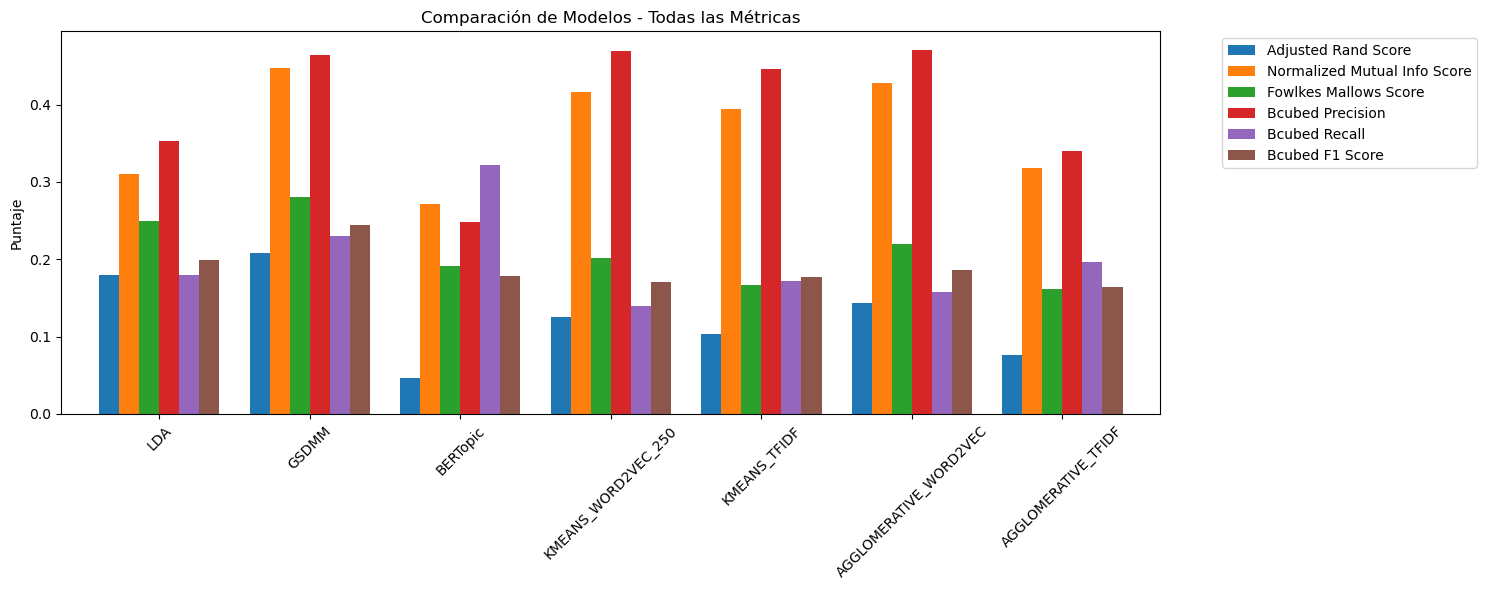

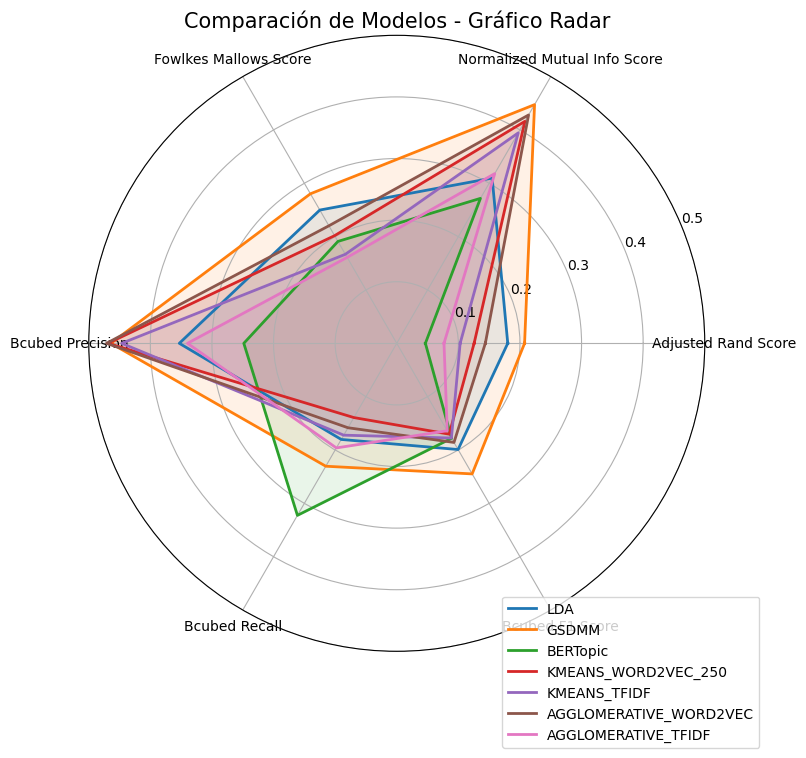

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Datos de evaluación
models = [
    "LDA", "GSDMM", "BERTopic", "KMEANS_WORD2VEC_250", 
    "KMEANS_TFIDF", "AGGLOMERATIVE_WORD2VEC", "AGGLOMERATIVE_TFIDF"
]

metrics = [
    "Adjusted Rand Score", "Normalized Mutual Info Score", 
    "Fowlkes Mallows Score", "Bcubed Precision", 
    "Bcubed Recall", "Bcubed F1 Score"
]

scores = np.array([
    [0.1802, 0.3097, 0.2498, 0.3530, 0.1802, 0.1991],
    [0.2075, 0.4474, 0.2803, 0.4641, 0.2304, 0.2448],
    [0.0465, 0.2717, 0.1910, 0.2483, 0.3225, 0.1780],
    [0.1256, 0.4161, 0.2018, 0.4690, 0.1392, 0.1703],
    [0.1029, 0.3945, 0.1669, 0.4466, 0.1722, 0.1775],
    [0.1438, 0.4280, 0.2203, 0.4712, 0.1583, 0.1858],
    [0.0767, 0.3181, 0.1611, 0.3397, 0.1961, 0.1639]
])

# Crear un DataFrame para los datos

df = pd.DataFrame(scores, index=models, columns=metrics)

# Calcular promedio por modelo y ordenarlos
average_scores = df.mean(axis=1).sort_values(ascending=False)
df['Average Score'] = average_scores

#Mostrar promedio ordenados
print("Promedio por modelo (ordenados de mayor a menor):\n")
print(df[['Average Score']].sort_values(by='Average Score', ascending=False))

# Plot de Barras Agrupadas
plt.figure(figsize=(15, 6))
df.iloc[:, :-1].plot(kind='bar', width=0.8, figsize=(15, 6))
plt.title("Comparación de Modelos - Todas las Métricas")
plt.ylabel("Puntaje")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot de Radar para cada modelo
num_vars = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for i, (model, row) in enumerate(df.iloc[:, :-1].iterrows()):
    values = row.tolist()
    values += values[:1]  # Cerrar el gráfico circular
    angles_with_closure = angles + [angles[0]]  # Asegurar que coincidan los ángulos
    ax.plot(angles_with_closure, values, label=model, linewidth=2)
    ax.fill(angles_with_closure, values, alpha=0.1)

ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5'])
ax.set_xticks(angles)
ax.set_xticklabels(metrics)
ax.set_title("Comparación de Modelos - Gráfico Radar", size=15)
ax.legend(bbox_to_anchor=(1.1, 0.1))
plt.show()


In [13]:
df_f1

LDA                       0.1991
GSDMM                     0.2448
BERTopic                  0.1780
KMEANS_WORD2VEC_250       0.1703
KMEANS_TFIDF              0.1775
AGGLOMERATIVE_WORD2VEC    0.1858
AGGLOMERATIVE_TFIDF       0.1639
Name: Bcubed F1 Score, dtype: float64